**временные ряды и модели ARIMA**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k

-----

#  загружаем данные

In [1]:
import numpy as np
from numpy import random as rng
import pandas as pd
import matplotlib.pyplot as plt

__monthly totals of a US airline passengers from 1949 to 1960__

In [2]:
# AirPassengers.csv :
#    https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link
#    https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
df = pd.read_csv(url).convert_dtypes()

df['date'] = pd.to_datetime(df['Month'])
df = df.set_index('date')
df = df.asfreq('MS')
df = df[['#Passengers']].rename(columns={'#Passengers':'values'})

display(df.sample(3))

,values
date,
1957-05-01,355
1958-11-01,310
1955-06-01,315


# анализ данных

__1. визуальная оценка данных__

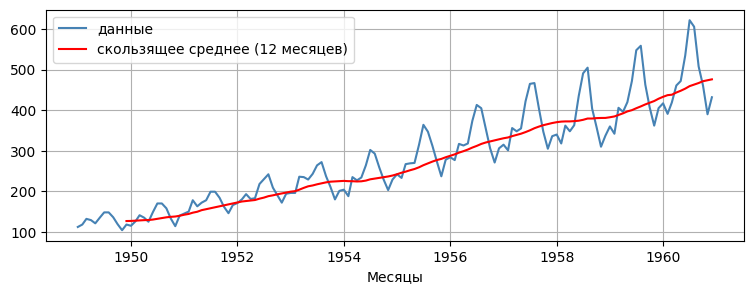

In [3]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['values'], label = 'данные', color = 'steelblue')
ax.plot(df['values'].rolling(window=12).mean(), label = 'скользящее среднее (12 месяцев)', color = 'red')
ax.set_xlabel('Месяцы', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оценка автокорреляции__

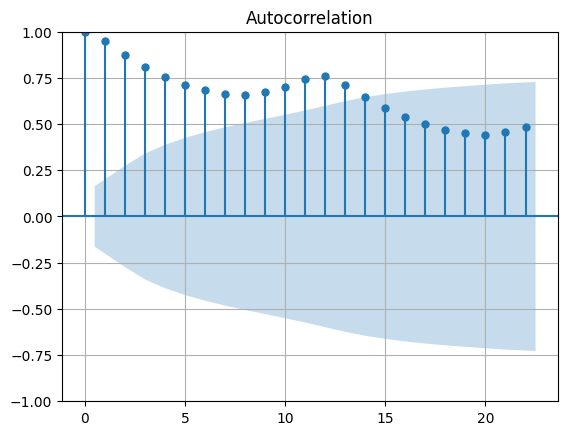

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['values'])
plt.grid()
plt.show()

__ряд имеет растущую амплитуду, стабилизируем дисперсию__

применяем преобразование Бокса-Кокса

In [5]:
from scipy.special import boxcox
df['bcx'] = boxcox( df['values'],0 )

In [6]:
# from scipy.special import inv_boxcox
# df['bcx_inv'] = inv_boxcox(df['bcx'],0)

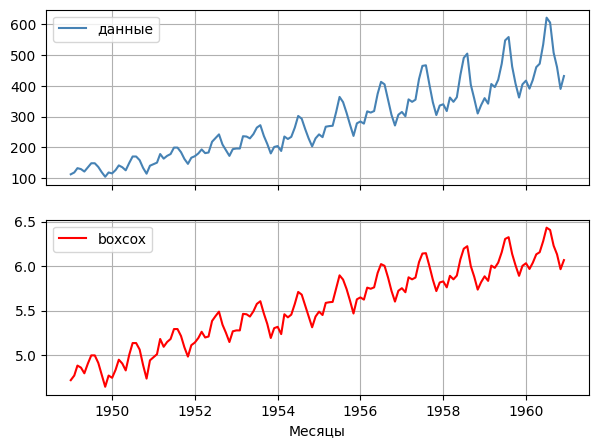

In [7]:
fig,ax = plt.subplots(2,1, figsize = (7,5),sharex=True)
ax[0].plot(df['values'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bcx'], label = 'boxcox', color = 'red')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].set_xlabel('Месяцы', )
ax[1].grid()

## подбираем гиперпараметры модели

__оценка сезонности__

In [8]:
# !pip install statsmodels

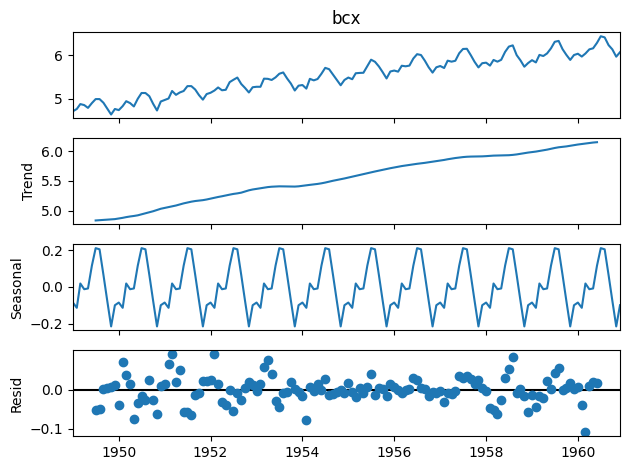

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['bcx'])
fig = decompose.plot()
plt.show()

In [10]:
S = 12 # выбираем шаг сезонности 

__оценка стационарности ряда  (критерий Дики-Фуллера)__

In [11]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['bcx'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.4223667747703874


__оценка высокая, ряд нестационарный__

подбираем порядок дифференцирования d,D

In [12]:
# дифференцирование
df['dif'] = df['bcx'].diff()
adf_test = adfuller(df['dif'].fillna(0.))
print('p-value = ' + str(adf_test[1]))

p-value = 0.07859381719564043


In [13]:
# сезонное дифференцирование
df['dif_s'] = df['bcx'].diff(S)
adf_test = adfuller(df['dif_s'].fillna(0.))
print('p-value = ' + str(adf_test[1]))

p-value = 0.009417182340649867


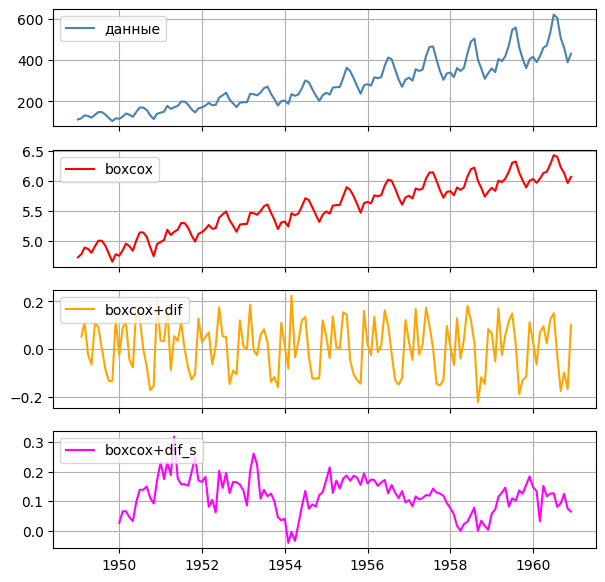

In [14]:
fig,ax = plt.subplots(4,1, figsize = (7,7),sharex=True)
ax[0].plot(df['values'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bcx'], label = 'boxcox', color = 'red')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].grid()

ax[2].plot(df['dif'], label = 'boxcox+dif', color = 'orange')
ax[2].legend(title = '', loc = 'upper left', )
ax[2].grid()

ax[3].plot(df['dif_s'], label = 'boxcox+dif_s', color = 'magenta')
ax[3].legend(title = '', loc = 'upper left', )
ax[3].grid()

In [15]:
d,D = 1,1 # выбираем количество шагов дифференцирования

__3. анализируем автокорреляции__

подбираем p,q и P,Q

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

---

In [17]:
n_lags = S+1

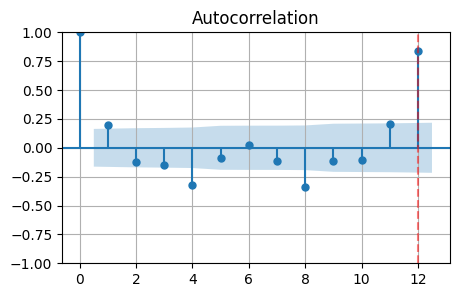

In [18]:
fig,ax = plt.subplots(figsize=(5,3))
plot_acf( df['dif'].fillna(0.), lags=range(n_lags), ax=ax )
ax.plot([S,S],[-1,1],color='red',linestyle='dashed',alpha=.5)
ax.grid()

q - номер последнего НЕсезонного лага, при котором __автокорреляция__ значима, но меньше длинны сезона ;    

In [19]:
q = 8

---

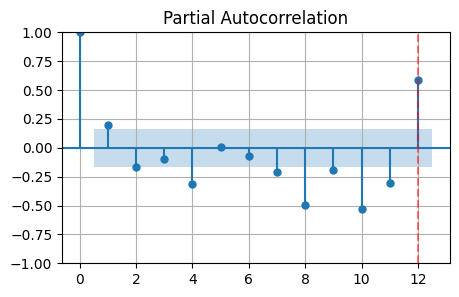

In [20]:
fig,ax = plt.subplots(figsize=(5,3))
plot_pacf(df['dif'].fillna(0.),lags=range(n_lags),ax=ax)
ax.plot([S,S],[-1,1],color='red',linestyle='dashed',alpha=.5)
ax.grid()

p - номер последнего НЕсезонного лага, при котором __частичной автокорреляция__ значима, но меньше длинны сезона ;   

In [21]:
p = 11

---

In [22]:
n_ses_lags = 7

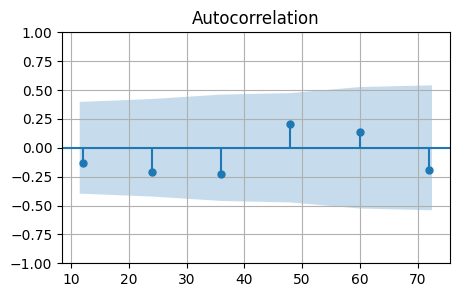

In [23]:
lags = np.arange(1*S,n_ses_lags*S,S)
fig,ax = plt.subplots(figsize=(5,3))
plot_acf(df['dif_s'].fillna(0.),lags=lags,ax=ax)
ax.grid()

Q - номер последнего сезонного лага, при котором __автокорреляция__ значима, но меньше длинны сезона ;    

In [24]:
Q = 0

---

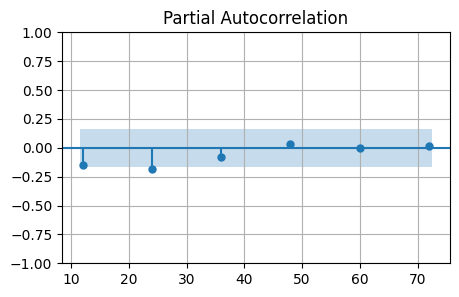

In [25]:
lags = np.arange(1*S,n_ses_lags*S,S)
fig,ax = plt.subplots(figsize=(5,3))
plot_pacf(df['dif_s'].fillna(0.),lags=lags,ax=ax)
ax.grid()

P - номер последнего сезонного лага, при котором __частичной автокорреляция__ значима, но меньше длинны сезона ;   

In [26]:
P = 2

# разделяем данные 

In [27]:
display( df.index.min(), df.index.max() )

Timestamp('1949-01-01 00:00:00')

Timestamp('1960-12-01 00:00:00')

In [28]:
# разобьём данные на обучающую и тестовую выборки
train = df[:'1959-12']
test = df['1960-01':]

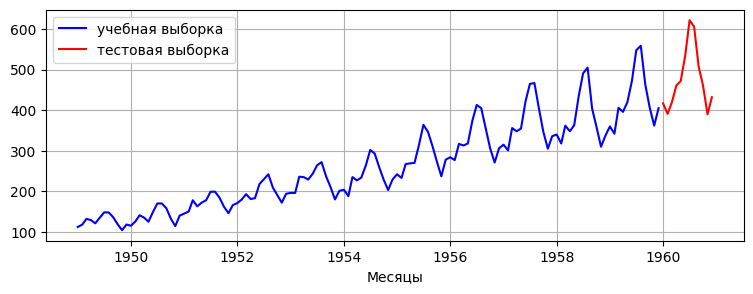

In [29]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['values'], color = 'blue',label='учебная выборка')
ax.plot(test['values'], color = 'red',label='тестовая выборка')
ax.set_xlabel('Месяцы', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

# обучаем модель

In [30]:
display( 'SARIMAX ({},{},{}), ({},{},{}), {}'.format(p,d,q,P,D,Q,S) )

'SARIMAX (11,1,8), (2,1,0), 12'

In [31]:
%%time 

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX (p,d,q),(P,D,Q),S
model = SARIMAX(
        train['bcx'], 
        order = (p, d, q),
        seasonal_order = (P, D, Q, S)
    ).fit()
    
    # method='cg', ) #    method='lbfgs',full_output=False)

/opt/venv/sevgu_1/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38145D+00    |proj g|=  2.21895D+01

At iterate    5    f= -1.48552D+00    |proj g|=  3.49827D-01

At iterate   10    f= -1.58743D+00    |proj g|=  1.21054D+00

At iterate   15    f= -1.60064D+00    |proj g|=  2.91650D+00

At iterate   20    f= -1.67746D+00    |proj g|=  1.24774D+00

At iterate   25    f= -1.71319D+00    |proj g|=  1.55858D+00

At iterate   30    f= -1.71540D+00    |proj g|=  1.26994D+00

At iterate   35    f= -1.72903D+00    |proj g|=  7.04106D-01

At iterate   40    f= -1.73055D+00    |proj g|=  6.30214D-01

At iterate   45    f= -1.73295D+00    |proj g|=  3.78564D-01

At iterate   50    f= -1.73413D+00    |proj g|=  1.75726D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/venv/sevgu_1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 27.6 s, sys: 10.2 ms, total: 27.6 s
Wall time: 4.69 s


In [32]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  bcx   No. Observations:                  132
Model:             SARIMAX(11, 1, 8)x(2, 1, [], 12)   Log Likelihood                 228.906
Date:                              Wed, 24 Apr 2024   AIC                           -413.811
Time:                                      19:17:09   BIC                           -352.671
Sample:                                  01-01-1949   HQIC                          -388.984
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0148      0.851      0.017      0.986      -1.653       1.682
ar.L2          0.08

# тестируем

In [33]:
start,end  = len(train), len(train)+len(test)-1

predicted = model.predict(start, end)

__применяли преобразование Бокса-Кокса__    
__нужно выполнить обратное преобразование__

In [34]:
from scipy.special import inv_boxcox
predicted = inv_boxcox( predicted, 0 )

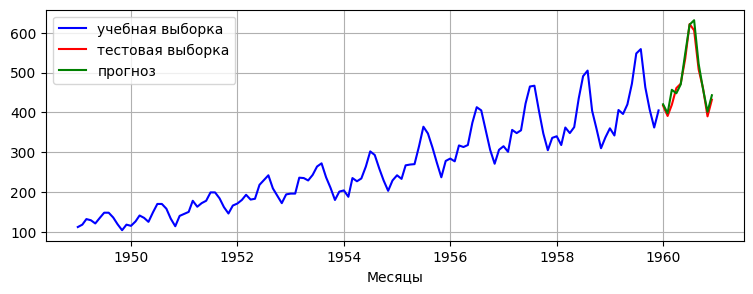

In [35]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['values'], color = 'blue',label='учебная выборка')
ax.plot(test['values'], color = 'red',label='тестовая выборка')
ax.plot(predicted, color = 'green',  label='прогноз')
ax.set_xlabel('Месяцы', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оцениваем остатки (разница между прогнозом и тестовыми данными)__

In [36]:
start,end  = 0, len(df)

predicted = model.predict(start, end)

# применяли преобразование Бокса-Кокса, выполняем обратное преобразование
predicted = inv_boxcox( predicted, 0 )

In [37]:
err = df['values'] - predicted

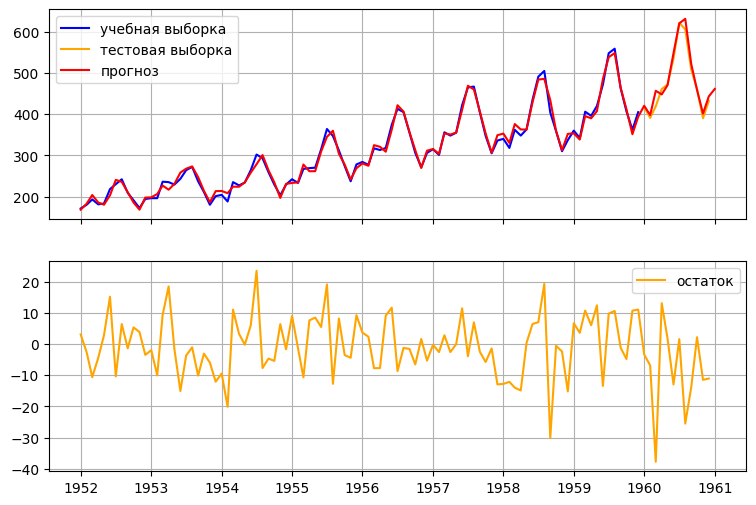

In [38]:
n_skip = 12*3

fig,ax = plt.subplots(2,1,figsize = (9,6),sharex=True)
ax[0].plot(train[n_skip:]['values'], color = 'blue',label='учебная выборка')
ax[0].plot(test['values'], color = 'orange',label='тестовая выборка')
ax[0].plot(predicted[n_skip:], color = 'red',label='прогноз')
ax[0].grid()
ax[0].legend()
ax[1].plot(err[n_skip:], color = 'orange',label='остаток')
ax[1].grid()
ax[1].legend()

__оценка автокореляции остатков__

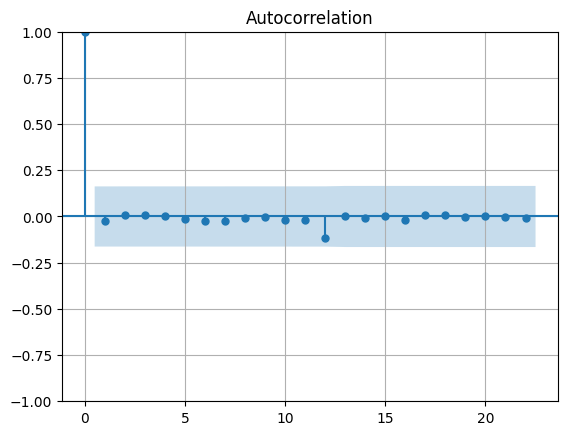

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(err.fillna(0.))
plt.grid()
plt.show()

# строим прогноз

In [40]:
forecast_periods = S*4 # на n сезонов вперед
forecast = model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean # значение прогноза
forecast_mean = inv_boxcox( forecast_mean,0)
forecast_ci = forecast.conf_int() # предсказательный интервал
forecast_ci = inv_boxcox( forecast_ci, 0 )

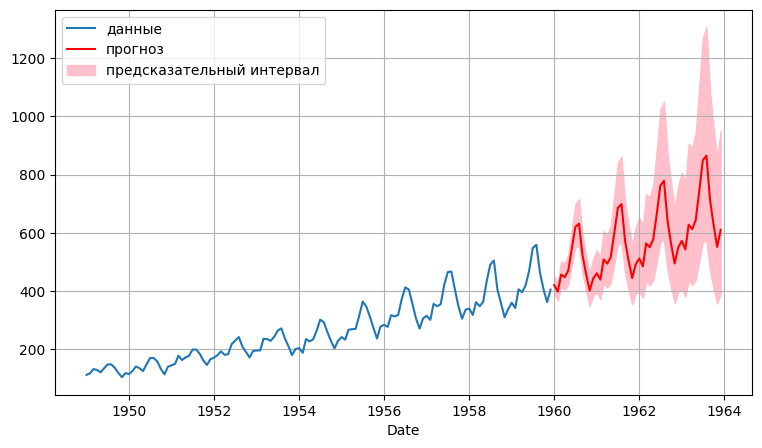

In [41]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(train['values'], label='данные')
ax.plot(forecast_mean, label='прогноз', color='red')
ax.fill_between(
        forecast_ci.index, 
        forecast_ci.iloc[:, 0], 
        forecast_ci.iloc[:, 1], 
        color='pink', 
        label='предсказательный интервал'
    )
ax.set_xlabel("Date")
ax.legend(loc='upper left')
ax.grid()